In [1]:
import os
import time

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as mpanim
from IPython import display
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as tv_utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# Preparing the Dataset and Data Loader

In [4]:
DATASET_DIR = os.path.abspath("../data/images")
BATCH_SIZE = 32
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
NUM_CHANNELS = 3
LATENT_VECTOR_SIZE = 100
GEN_FMAP_SIZE = 64
DIS_FMAP_SIZE = 64
NGPU = 1
LEARNING_RATE = 0.0002
BETA_1 = 0.5

In [5]:
DATASET_DIR

'/home/ubuntu/tgdne/data/images'

In [6]:
dataset = datasets.ImageFolder(
    root = DATASET_DIR,
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

In [7]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Example Batch

Here we'll visualize a single batch of training images,

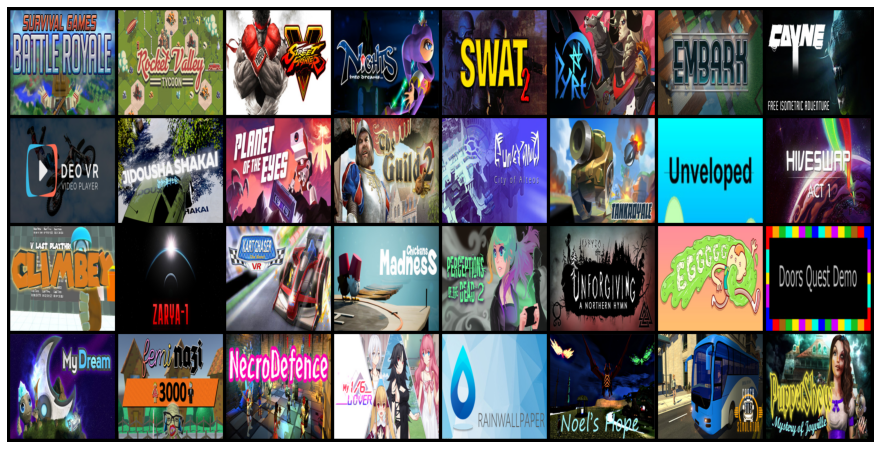

In [8]:
test_batch = next(iter(dataloader))
plt.figure(figsize=(32, 8))
plt.axis("off")

image_grid = np.transpose(tv_utils.make_grid(test_batch[0].to("cpu")[:BATCH_SIZE], padding=8, normalize=True).cpu(), (1, 2, 0))

plt.imshow(image_grid)

In [9]:
def arr_to_image(data: np.ndarray):
    return Image.fromarray((255.0 / data.max() * (data - data.min())).astype(np.uint8))

In [10]:
img = arr_to_image(image_grid.numpy())

In [11]:
img.save("tmp.jpg")

# Building the Model

This model is heavily based on the official PyTorch tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
DEBUG = True

class debug_layer(nn.Module):
    def __init__(self, enabled, prefix):
        super().__init__()
        self.enabled = enabled
        self.prefix = prefix
    
    def forward(self, x):
        if self.enabled:
            print(self.prefix, x.shape)
        return x

In [14]:
print(DIS_FMAP_SIZE)
print(DIS_FMAP_SIZE * 2)
print(DIS_FMAP_SIZE * 4)
print(DIS_FMAP_SIZE * 8)
print(DIS_FMAP_SIZE * 16)
print(DIS_FMAP_SIZE * 32)

64
128
256
512
1024
2048


In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_VECTOR_SIZE, GEN_FMAP_SIZE * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 64, GEN_FMAP_SIZE * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE * 32, GEN_FMAP_SIZE * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE * 16, GEN_FMAP_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 4, GEN_FMAP_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 2, GEN_FMAP_SIZE, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

In [16]:
net_g = Generator(NGPU).to(device)
net_g.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [17]:
kernel = 4
stride = 2

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(NUM_CHANNELS, DIS_FMAP_SIZE, kernel, stride, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(DIS_FMAP_SIZE, DIS_FMAP_SIZE * 2, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 2, DIS_FMAP_SIZE * 4, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 4, DIS_FMAP_SIZE * 8, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 8, DIS_FMAP_SIZE * 16, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 16, DIS_FMAP_SIZE * 32, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 32, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [18]:
net_d = Discriminator(NGPU).to(device)
net_d.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [19]:
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(32, LATENT_VECTOR_SIZE, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizer_d = optim.Adam(net_d.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))

In [20]:
start_time = int(time.time())

num_epochs = 50
img_list = []
g_losses = []
d_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # Loop over batches
    for i, data in enumerate(dataloader, 0):

        # Train discriminator
        
        # Train with all-real batch
        net_d.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = net_d(real_cpu).view(-1)

        err_d_real = criterion(output, label)

        err_d_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, LATENT_VECTOR_SIZE, 1, 1, device=device)

        fake = net_g(noise)
        label.fill_(fake_label)

        output = net_d(fake.detach()).view(-1)

        err_d_fake = criterion(output, label)

        err_d_fake.backward()
        D_G_z1 = output.mean().item()

        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()

        # Train generator
        net_g.zero_grad()
        label.fill_(real_label)

        output = net_d(fake).view(-1)

        err_g = criterion(output, label)

        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err_d.item(), err_g.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        g_losses.append(err_g.item())
        d_losses.append(err_d.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 25 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_grid = tv_utils.make_grid(fake, padding=2, normalize=True).cpu().numpy()
            img_grid = np.transpose(img_grid, (1, 2, 0))
#             img_list.append(img_grid)
            pil_img_grid = arr_to_image(img_grid)
            pil_img_grid.save(f"../data/models/headergen/images/{start_time}-{epoch}-{err_g.item()}-{err_d.item()}.jpg")

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 2500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            torch.save(net_g.state_dict(), f"../data/models/headergen/models/gen-{start_time}-{epoch}-{err_g.item()}.pth")
            torch.save(net_d.state_dict(), f"../data/models/headergen/models/dis-{start_time}-{epoch}-{err_d.item()}.pth")
            
        iters += 1

Starting Training Loop...
[0/50][0/846]	Loss_D: 2.8917	Loss_G: 60.6011	D(x): 1.4214	D(G(z)): 1.7962 / -60.6011
[0/50][50/846]	Loss_D: 2.8932	Loss_G: 14.7488	D(x): 1.2107	D(G(z)): -8.0193 / -14.7485
[0/50][100/846]	Loss_D: 2.4810	Loss_G: 2.4067	D(x): -1.3423	D(G(z)): -4.4807 / -1.7494
[0/50][150/846]	Loss_D: 1.2266	Loss_G: 5.0108	D(x): 0.0558	D(G(z)): -5.3221 / -4.9745
[0/50][200/846]	Loss_D: 0.3218	Loss_G: 5.9799	D(x): 5.5339	D(G(z)): -2.8960 / -5.9643
[0/50][250/846]	Loss_D: 1.6161	Loss_G: 13.3427	D(x): 0.5707	D(G(z)): -8.6946 / -13.3386
[0/50][300/846]	Loss_D: 0.2367	Loss_G: 4.7587	D(x): 3.0291	D(G(z)): -3.7482 / -4.7348
[0/50][350/846]	Loss_D: 0.4858	Loss_G: 4.8151	D(x): 2.8716	D(G(z)): -6.8195 / -4.6350
[0/50][400/846]	Loss_D: 1.6020	Loss_G: 7.2517	D(x): 2.4780	D(G(z)): 0.5098 / -7.2492
[0/50][450/846]	Loss_D: 0.5915	Loss_G: 3.9725	D(x): 2.8181	D(G(z)): -2.0684 / -3.9343


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[0/50][500/846]	Loss_D: 0.3976	Loss_G: 4.9671	D(x): 2.8989	D(G(z)): -6.9095 / -4.8769
[0/50][550/846]	Loss_D: 0.4589	Loss_G: 5.5796	D(x): 5.0024	D(G(z)): -1.7475 / -5.5699
[0/50][600/846]	Loss_D: 0.6002	Loss_G: 1.8896	D(x): 1.3712	D(G(z)): -4.2037 / -1.6066


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[0/50][650/846]	Loss_D: 0.4898	Loss_G: 5.7952	D(x): 4.4196	D(G(z)): -1.5709 / -5.7846
[0/50][700/846]	Loss_D: 0.4914	Loss_G: 3.5937	D(x): 1.6349	D(G(z)): -3.9330 / -3.5304
[0/50][750/846]	Loss_D: 1.5719	Loss_G: 8.6357	D(x): 0.3866	D(G(z)): -1.9841 / -8.6306
[0/50][800/846]	Loss_D: 1.4633	Loss_G: 9.7046	D(x): 5.3016	D(G(z)): -0.2974 / -9.6597
[1/50][0/846]	Loss_D: 0.2794	Loss_G: 4.4362	D(x): 2.4514	D(G(z)): -4.8515 / -4.3959
[1/50][50/846]	Loss_D: 1.5234	Loss_G: 7.4804	D(x): 5.4672	D(G(z)): 0.5900 / -7.4787
[1/50][100/846]	Loss_D: 0.8813	Loss_G: 8.8572	D(x): 6.4707	D(G(z)): -0.2283 / -8.8568


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[1/50][150/846]	Loss_D: 1.7433	Loss_G: 3.7422	D(x): 0.5627	D(G(z)): -1.2186 / -3.7022
[1/50][200/846]	Loss_D: 0.3417	Loss_G: 4.5168	D(x): 5.4969	D(G(z)): -1.6096 / -4.4892
[1/50][250/846]	Loss_D: 2.6281	Loss_G: 5.9453	D(x): -2.1253	D(G(z)): -8.0044 / -5.9256


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[1/50][300/846]	Loss_D: 0.2332	Loss_G: 6.3082	D(x): 4.8729	D(G(z)): -5.4189 / -6.2947
[1/50][350/846]	Loss_D: 0.1785	Loss_G: 7.1632	D(x): 2.7071	D(G(z)): -5.8148 / -7.1597
[1/50][400/846]	Loss_D: 1.1961	Loss_G: 3.9415	D(x): 1.2585	D(G(z)): -1.2705 / -3.8995
[1/50][450/846]	Loss_D: 0.4873	Loss_G: 5.4478	D(x): 2.3140	D(G(z)): -4.9464 / -5.4339
[1/50][500/846]	Loss_D: 0.1893	Loss_G: 10.5734	D(x): 3.5408	D(G(z)): -7.7957 / -10.5732
[1/50][550/846]	Loss_D: 0.2534	Loss_G: 5.3472	D(x): 3.5993	D(G(z)): -5.4165 / -5.3321
[1/50][600/846]	Loss_D: 0.7906	Loss_G: 7.1039	D(x): 6.6732	D(G(z)): -3.3066 / -7.0933
[1/50][650/846]	Loss_D: 0.3806	Loss_G: 8.7780	D(x): 4.1335	D(G(z)): -2.4859 / -8.7776
[1/50][700/846]	Loss_D: 1.0752	Loss_G: 3.9710	D(x): 0.6862	D(G(z)): -4.2459 / -3.8927
[1/50][750/846]	Loss_D: 1.7421	Loss_G: 4.8595	D(x): 2.6305	D(G(z)): 0.3210 / -4.8211
[1/50][800/846]	Loss_D: 0.6387	Loss_G: 2.3845	D(x): 1.9681	D(G(z)): -2.2919 / -2.2412
[2/50][0/846]	Loss_D: 1.5689	Loss_G: 5.2205	D(x): -0.

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[2/50][50/846]	Loss_D: 1.0217	Loss_G: 3.7515	D(x): 2.0365	D(G(z)): -0.7142 / -3.6748
[2/50][100/846]	Loss_D: 0.0479	Loss_G: 8.6621	D(x): 5.3557	D(G(z)): -5.1438 / -8.6613


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[2/50][150/846]	Loss_D: 0.9438	Loss_G: 2.2672	D(x): 0.3667	D(G(z)): -5.0587 / -2.0489
[2/50][200/846]	Loss_D: 0.6087	Loss_G: 3.9363	D(x): 1.8641	D(G(z)): -1.7222 / -3.8301
[2/50][250/846]	Loss_D: 1.2079	Loss_G: 8.3913	D(x): 5.9902	D(G(z)): 0.6222 / -8.3906
[2/50][300/846]	Loss_D: 1.0680	Loss_G: 4.2823	D(x): 0.5554	D(G(z)): -6.0488 / -4.2507
[2/50][350/846]	Loss_D: 1.1625	Loss_G: 7.8618	D(x): 2.9760	D(G(z)): -0.3068 / -7.8610
[2/50][400/846]	Loss_D: 0.9860	Loss_G: 1.3093	D(x): 0.8173	D(G(z)): -2.3251 / -0.6935
[2/50][450/846]	Loss_D: 1.2660	Loss_G: 2.9633	D(x): -0.1284	D(G(z)): -3.5516 / -2.7364
[2/50][500/846]	Loss_D: 0.6931	Loss_G: 8.7101	D(x): 1.0074	D(G(z)): -8.2480 / -8.7079
[2/50][550/846]	Loss_D: 0.6852	Loss_G: 4.9589	D(x): 1.2894	D(G(z)): -1.7355 / -4.9482
[2/50][600/846]	Loss_D: 0.3884	Loss_G: 6.0868	D(x): 2.6833	D(G(z)): -2.1129 / -6.0818
[2/50][650/846]	Loss_D: 4.0003	Loss_G: 3.5971	D(x): -3.9116	D(G(z)): -9.9915 / -3.5422
[2/50][700/846]	Loss_D: 1.0610	Loss_G: 3.8458	D(x): 0

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[3/50][50/846]	Loss_D: 1.5462	Loss_G: 2.1814	D(x): -0.4955	D(G(z)): -1.4503 / -1.9070
[3/50][100/846]	Loss_D: 1.2638	Loss_G: 3.9703	D(x): 1.1502	D(G(z)): -1.0660 / -3.9134
[3/50][150/846]	Loss_D: 1.4431	Loss_G: 4.5497	D(x): -0.8460	D(G(z)): -6.8175 / -4.5122
[3/50][200/846]	Loss_D: 0.8741	Loss_G: 3.4598	D(x): 0.2973	D(G(z)): -4.5280 / -3.3686
[3/50][250/846]	Loss_D: 0.4625	Loss_G: 3.7954	D(x): 2.1362	D(G(z)): -2.0602 / -3.7459
[3/50][300/846]	Loss_D: 0.4704	Loss_G: 3.0013	D(x): 1.8118	D(G(z)): -2.8598 / -2.9149
[3/50][350/846]	Loss_D: 0.4532	Loss_G: 4.9452	D(x): 2.8527	D(G(z)): -2.0438 / -4.9312


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[3/50][400/846]	Loss_D: 0.9398	Loss_G: 3.1062	D(x): 0.8462	D(G(z)): -1.0918 / -3.0454
[3/50][450/846]	Loss_D: 0.3793	Loss_G: 4.2316	D(x): 2.4187	D(G(z)): -2.2021 / -4.2099
[3/50][500/846]	Loss_D: 0.8160	Loss_G: 1.3254	D(x): 0.4627	D(G(z)): -2.8092 / -0.8322
[3/50][550/846]	Loss_D: 1.7660	Loss_G: 5.0268	D(x): 4.0615	D(G(z)): 1.2230 / -5.0094
[3/50][600/846]	Loss_D: 0.9407	Loss_G: 4.1632	D(x): 3.7214	D(G(z)): -0.1926 / -4.1318
[3/50][650/846]	Loss_D: 2.4388	Loss_G: 4.5229	D(x): -2.2553	D(G(z)): -6.8311 / -4.4960
[3/50][700/846]	Loss_D: 0.5853	Loss_G: 4.1055	D(x): 2.3244	D(G(z)): -1.4574 / -4.0704
[3/50][750/846]	Loss_D: 1.3789	Loss_G: 5.1094	D(x): 4.9042	D(G(z)): 0.9335 / -5.0988
[3/50][800/846]	Loss_D: 1.7088	Loss_G: 3.4052	D(x): -0.9216	D(G(z)): -4.4152 / -3.3294
[4/50][0/846]	Loss_D: 1.4698	Loss_G: 3.0819	D(x): 2.5889	D(G(z)): 0.3461 / -2.9673
[4/50][50/846]	Loss_D: 2.5714	Loss_G: 5.2214	D(x): -2.3792	D(G(z)): -8.0669 / -5.2021
[4/50][100/846]	Loss_D: 0.8446	Loss_G: 3.9872	D(x): 0.419

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[4/50][650/846]	Loss_D: 1.5100	Loss_G: 4.7004	D(x): 1.1932	D(G(z)): 0.2185 / -4.6805
[4/50][700/846]	Loss_D: 0.5505	Loss_G: 1.5712	D(x): 1.3205	D(G(z)): -4.3298 / -1.1065


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[4/50][750/846]	Loss_D: 1.4738	Loss_G: 9.0220	D(x): 2.5879	D(G(z)): 0.6075 / -9.0217
[4/50][800/846]	Loss_D: 0.5535	Loss_G: 4.7519	D(x): 4.1249	D(G(z)): -0.9280 / -4.7380
[5/50][0/846]	Loss_D: 0.7478	Loss_G: 3.5499	D(x): 2.9517	D(G(z)): -0.4201 / -3.5003


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[5/50][50/846]	Loss_D: 0.8170	Loss_G: 5.9436	D(x): 1.5411	D(G(z)): -1.2600 / -5.9337
[5/50][100/846]	Loss_D: 0.6033	Loss_G: 5.1537	D(x): 2.5942	D(G(z)): -1.8730 / -5.1414
[5/50][150/846]	Loss_D: 1.4924	Loss_G: 5.9529	D(x): 2.4602	D(G(z)): -0.2689 / -5.9468
[5/50][200/846]	Loss_D: 0.7142	Loss_G: 2.3606	D(x): 1.0868	D(G(z)): -3.2807 / -2.1967
[5/50][250/846]	Loss_D: 0.5953	Loss_G: 3.6283	D(x): 1.7587	D(G(z)): -1.2425 / -3.5918
[5/50][300/846]	Loss_D: 0.7895	Loss_G: 3.9049	D(x): 1.5353	D(G(z)): -1.3038 / -3.8720
[5/50][350/846]	Loss_D: 1.6346	Loss_G: 6.5297	D(x): 4.2807	D(G(z)): 1.1810 / -6.5264
[5/50][400/846]	Loss_D: 1.0805	Loss_G: 2.7380	D(x): -0.2645	D(G(z)): -4.5509 / -2.5084
[5/50][450/846]	Loss_D: 1.0203	Loss_G: 2.7368	D(x): 0.8498	D(G(z)): -2.5458 / -2.6226


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[5/50][500/846]	Loss_D: 0.3445	Loss_G: 5.5619	D(x): 4.1639	D(G(z)): -1.7048 / -5.5548
[5/50][550/846]	Loss_D: 0.5548	Loss_G: 2.8880	D(x): 1.6747	D(G(z)): -2.1097 / -2.7619
[5/50][600/846]	Loss_D: 0.8978	Loss_G: 3.4171	D(x): 0.7203	D(G(z)): -3.6985 / -3.3657
[5/50][650/846]	Loss_D: 0.9433	Loss_G: 8.8195	D(x): 3.5379	D(G(z)): -0.1969 / -8.8190
[5/50][700/846]	Loss_D: 2.0421	Loss_G: 8.1433	D(x): 4.2769	D(G(z)): 1.6799 / -8.1426
[5/50][750/846]	Loss_D: 1.8609	Loss_G: 7.6229	D(x): 2.2202	D(G(z)): 1.1836 / -7.6218
[5/50][800/846]	Loss_D: 0.7970	Loss_G: 6.2589	D(x): 0.3996	D(G(z)): -6.9018 / -6.2544
[6/50][0/846]	Loss_D: 4.6925	Loss_G: 6.4622	D(x): -4.6727	D(G(z)): -12.1606 / -6.4452
[6/50][50/846]	Loss_D: 0.6441	Loss_G: 4.3856	D(x): 2.3012	D(G(z)): -1.4511 / -4.3585
[6/50][100/846]	Loss_D: 0.4284	Loss_G: 3.1701	D(x): 1.7552	D(G(z)): -2.5281 / -3.1038
[6/50][150/846]	Loss_D: 0.5940	Loss_G: 6.5152	D(x): 3.6872	D(G(z)): -0.7467 / -6.5131


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[6/50][200/846]	Loss_D: 2.1733	Loss_G: 9.6321	D(x): 4.4421	D(G(z)): 1.8681 / -9.6319


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[6/50][250/846]	Loss_D: 0.5800	Loss_G: 6.6797	D(x): 3.5817	D(G(z)): -0.7897 / -6.6770
[6/50][300/846]	Loss_D: 0.8515	Loss_G: 7.0953	D(x): 3.5701	D(G(z)): -0.1998 / -7.0940
[6/50][350/846]	Loss_D: 1.6081	Loss_G: 3.2862	D(x): -1.0503	D(G(z)): -7.4874 / -3.0956
[6/50][400/846]	Loss_D: 2.2181	Loss_G: 11.4559	D(x): 4.6050	D(G(z)): 1.9138 / -11.4559
[6/50][450/846]	Loss_D: 0.8368	Loss_G: 1.4925	D(x): 0.1572	D(G(z)): -4.1463 / -1.0643
[6/50][500/846]	Loss_D: 0.9109	Loss_G: 1.4575	D(x): 0.3013	D(G(z)): -3.5128 / -1.0854
[6/50][550/846]	Loss_D: 0.5635	Loss_G: 3.9382	D(x): 0.8377	D(G(z)): -6.0273 / -3.8602
[6/50][600/846]	Loss_D: 0.6514	Loss_G: 5.0068	D(x): 3.1466	D(G(z)): -0.7585 / -4.9959


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[6/50][650/846]	Loss_D: 4.3291	Loss_G: 3.9845	D(x): -4.2800	D(G(z)): -9.1620 / -3.9012
[6/50][700/846]	Loss_D: 0.4433	Loss_G: 5.4630	D(x): 5.2351	D(G(z)): -1.0556 / -5.4559
[6/50][750/846]	Loss_D: 2.2084	Loss_G: 15.1831	D(x): 6.7624	D(G(z)): 1.7402 / -15.1831
[6/50][800/846]	Loss_D: 0.4819	Loss_G: 6.4391	D(x): 2.1421	D(G(z)): -1.5188 / -6.4366
[7/50][0/846]	Loss_D: 2.1902	Loss_G: 9.9108	D(x): 5.3760	D(G(z)): 2.0111 / -9.9107


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[7/50][50/846]	Loss_D: 1.1848	Loss_G: 8.7091	D(x): 4.3964	D(G(z)): 0.5821 / -8.7088
[7/50][100/846]	Loss_D: 0.7597	Loss_G: 5.6934	D(x): 3.1834	D(G(z)): -1.0275 / -5.6758
[7/50][150/846]	Loss_D: 0.5044	Loss_G: 4.4929	D(x): 1.2013	D(G(z)): -3.9624 / -4.4680
[7/50][200/846]	Loss_D: 1.5164	Loss_G: 9.9309	D(x): 5.1475	D(G(z)): 1.1082 / -9.9308
[7/50][250/846]	Loss_D: 0.2265	Loss_G: 3.5452	D(x): 2.7380	D(G(z)): -3.3768 / -3.4815
[7/50][300/846]	Loss_D: 1.2590	Loss_G: 8.3067	D(x): 6.5553	D(G(z)): 0.5779 / -8.3061
[7/50][350/846]	Loss_D: 0.3165	Loss_G: 3.1883	D(x): 1.4611	D(G(z)): -4.1984 / -3.1196
[7/50][400/846]	Loss_D: 0.8225	Loss_G: 7.1109	D(x): 3.9088	D(G(z)): -0.1832 / -7.1091


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[7/50][450/846]	Loss_D: 0.3559	Loss_G: 6.2078	D(x): 3.6768	D(G(z)): -1.6798 / -6.2040
[7/50][500/846]	Loss_D: 1.2332	Loss_G: 6.0275	D(x): 2.8870	D(G(z)): 0.3480 / -6.0223
[7/50][550/846]	Loss_D: 0.4189	Loss_G: 4.6444	D(x): 1.3117	D(G(z)): -3.2448 / -4.6256
[7/50][600/846]	Loss_D: 0.8377	Loss_G: 3.0732	D(x): 1.2234	D(G(z)): -1.4406 / -2.8508
[7/50][650/846]	Loss_D: 1.8220	Loss_G: 3.8248	D(x): -1.5257	D(G(z)): -8.7667 / -3.7697
[7/50][700/846]	Loss_D: 1.2919	Loss_G: 8.7396	D(x): 4.6446	D(G(z)): 0.6209 / -8.7392
[7/50][750/846]	Loss_D: 0.3160	Loss_G: 3.9835	D(x): 3.0481	D(G(z)): -2.3520 / -3.9560
[7/50][800/846]	Loss_D: 0.2544	Loss_G: 6.2102	D(x): 1.7684	D(G(z)): -4.8470 / -6.2063
[8/50][0/846]	Loss_D: 0.4996	Loss_G: 5.4925	D(x): 4.4703	D(G(z)): -0.7374 / -5.4869
[8/50][50/846]	Loss_D: 0.1591	Loss_G: 5.2351	D(x): 4.4129	D(G(z)): -2.4392 / -5.2266
[8/50][100/846]	Loss_D: 0.5767	Loss_G: 3.0969	D(x): 0.9589	D(G(z)): -3.1652 / -3.0013
[8/50][150/846]	Loss_D: 1.0721	Loss_G: 1.5701	D(x): -0.270

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[8/50][650/846]	Loss_D: 0.6032	Loss_G: 7.8535	D(x): 3.9897	D(G(z)): -1.7944 / -7.8526
[8/50][700/846]	Loss_D: 0.6661	Loss_G: 6.0257	D(x): 2.5457	D(G(z)): -0.6636 / -6.0221


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[8/50][750/846]	Loss_D: 0.7178	Loss_G: 5.7891	D(x): 5.1911	D(G(z)): -0.6821 / -5.7836
[8/50][800/846]	Loss_D: 4.2060	Loss_G: 11.7078	D(x): 7.3404	D(G(z)): 4.1755 / -11.7078
[9/50][0/846]	Loss_D: 1.8615	Loss_G: 11.6596	D(x): 6.1218	D(G(z)): 1.4867 / -11.6596
[9/50][50/846]	Loss_D: 1.9156	Loss_G: 14.3829	D(x): 6.2388	D(G(z)): 1.6361 / -14.3829
[9/50][100/846]	Loss_D: 0.6646	Loss_G: 8.6695	D(x): 3.5903	D(G(z)): -0.6313 / -8.6692
[9/50][150/846]	Loss_D: 0.2606	Loss_G: 5.6575	D(x): 4.8242	D(G(z)): -2.6599 / -5.6503
[9/50][200/846]	Loss_D: 0.9437	Loss_G: 8.7526	D(x): 4.7244	D(G(z)): -0.0081 / -8.7523


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[9/50][250/846]	Loss_D: 0.5213	Loss_G: 4.8658	D(x): 3.1558	D(G(z)): -1.9323 / -4.8479


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[9/50][300/846]	Loss_D: 0.5228	Loss_G: 4.1576	D(x): 1.4564	D(G(z)): -4.5921 / -4.1062
[9/50][350/846]	Loss_D: 0.3213	Loss_G: 6.7307	D(x): 3.8691	D(G(z)): -2.3754 / -6.7282
[9/50][400/846]	Loss_D: 0.5780	Loss_G: 2.9959	D(x): 1.1921	D(G(z)): -3.9210 / -2.8559
[9/50][450/846]	Loss_D: 1.0342	Loss_G: 2.7670	D(x): 0.0210	D(G(z)): -6.5115 / -2.6526
[9/50][500/846]	Loss_D: 0.2658	Loss_G: 2.0026	D(x): 2.6566	D(G(z)): -3.5427 / -1.7664
[9/50][550/846]	Loss_D: 0.3981	Loss_G: 7.8570	D(x): 3.6664	D(G(z)): -1.7616 / -7.8563
[9/50][600/846]	Loss_D: 0.6972	Loss_G: 8.6614	D(x): 3.7541	D(G(z)): -0.2828 / -8.6610
[9/50][650/846]	Loss_D: 0.6222	Loss_G: 3.9357	D(x): 1.0571	D(G(z)): -3.2227 / -3.8835
[9/50][700/846]	Loss_D: 1.0196	Loss_G: 1.8082	D(x): 0.0594	D(G(z)): -3.7197 / -1.4279
[9/50][750/846]	Loss_D: 0.5406	Loss_G: 7.3936	D(x): 2.5605	D(G(z)): -1.5367 / -7.3922
[9/50][800/846]	Loss_D: 1.5902	Loss_G: 4.2585	D(x): -1.1135	D(G(z)): -7.5818 / -4.2172
[10/50][0/846]	Loss_D: 0.3671	Loss_G: 3.5025	D(x): 1.

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[10/50][350/846]	Loss_D: 0.6255	Loss_G: 8.8869	D(x): 3.8670	D(G(z)): -0.7297 / -8.8866
[10/50][400/846]	Loss_D: 0.8670	Loss_G: 8.1416	D(x): 0.2469	D(G(z)): -9.9311 / -8.1408


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[10/50][450/846]	Loss_D: 0.4935	Loss_G: 3.9971	D(x): 1.1010	D(G(z)): -4.7423 / -3.9594
[10/50][500/846]	Loss_D: 0.5847	Loss_G: 1.3637	D(x): 1.0411	D(G(z)): -2.8931 / -0.9061
[10/50][550/846]	Loss_D: 0.2574	Loss_G: 5.9366	D(x): 5.5365	D(G(z)): -2.4654 / -5.9311
[10/50][600/846]	Loss_D: 1.1549	Loss_G: 0.9962	D(x): 0.0769	D(G(z)): -1.8486 / -0.2155
[10/50][650/846]	Loss_D: 0.4342	Loss_G: 7.2683	D(x): 4.3161	D(G(z)): -1.5437 / -7.2670
[10/50][700/846]	Loss_D: 0.2408	Loss_G: 4.9184	D(x): 3.9580	D(G(z)): -2.3981 / -4.9023
[10/50][750/846]	Loss_D: 0.4334	Loss_G: 3.8022	D(x): 1.1724	D(G(z)): -4.0669 / -3.7640
[10/50][800/846]	Loss_D: 0.4749	Loss_G: 3.3830	D(x): 0.9715	D(G(z)): -6.0810 / -3.2979
[11/50][0/846]	Loss_D: 0.5432	Loss_G: 7.0068	D(x): 4.0078	D(G(z)): -1.3477 / -7.0046
[11/50][50/846]	Loss_D: 0.4035	Loss_G: 4.0082	D(x): 3.5174	D(G(z)): -1.8325 / -3.9709
[11/50][100/846]	Loss_D: 1.0526	Loss_G: 12.5945	D(x): 6.3720	D(G(z)): 0.3162 / -12.5945


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[11/50][150/846]	Loss_D: 0.5113	Loss_G: 4.0292	D(x): 1.3080	D(G(z)): -2.5749 / -4.0000
[11/50][200/846]	Loss_D: 0.0624	Loss_G: 8.1128	D(x): 3.9907	D(G(z)): -5.4254 / -8.1120
[11/50][250/846]	Loss_D: 0.0454	Loss_G: 3.5586	D(x): 5.0458	D(G(z)): -5.0879 / -3.4561
[11/50][300/846]	Loss_D: 0.1967	Loss_G: 6.0020	D(x): 4.0807	D(G(z)): -2.5493 / -5.9969


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[11/50][350/846]	Loss_D: 0.6056	Loss_G: 6.4649	D(x): 1.0112	D(G(z)): -7.6523 / -6.4599
[11/50][400/846]	Loss_D: 0.7383	Loss_G: 7.2554	D(x): 5.5417	D(G(z)): -0.7441 / -7.2538
[11/50][450/846]	Loss_D: 0.2257	Loss_G: 7.2833	D(x): 1.9802	D(G(z)): -5.8834 / -7.2816
[11/50][500/846]	Loss_D: 0.8733	Loss_G: 1.5975	D(x): 0.1244	D(G(z)): -5.1216 / -1.2041
[11/50][550/846]	Loss_D: 0.0637	Loss_G: 7.6804	D(x): 4.5719	D(G(z)): -5.3707 / -7.6782
[11/50][600/846]	Loss_D: 1.4533	Loss_G: 12.2104	D(x): 5.6825	D(G(z)): 0.7526 / -12.2104
[11/50][650/846]	Loss_D: 0.0565	Loss_G: 3.6868	D(x): 6.6941	D(G(z)): -4.1428 / -3.6047
[11/50][700/846]	Loss_D: 0.2202	Loss_G: 4.6518	D(x): 4.6871	D(G(z)): -2.2243 / -4.6344


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[11/50][750/846]	Loss_D: 1.2851	Loss_G: 6.2153	D(x): -0.7413	D(G(z)): -10.6538 / -6.2075
[11/50][800/846]	Loss_D: 1.7734	Loss_G: 5.1246	D(x): -1.4174	D(G(z)): -8.4024 / -5.1087
[12/50][0/846]	Loss_D: 0.9584	Loss_G: 8.4299	D(x): 0.0618	D(G(z)): -10.0021 / -8.4293


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[12/50][50/846]	Loss_D: 0.8086	Loss_G: 8.0971	D(x): 3.9263	D(G(z)): -0.7123 / -8.0966


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[12/50][100/846]	Loss_D: 2.5298	Loss_G: 14.5176	D(x): 9.9761	D(G(z)): 2.4070 / -14.5176
[12/50][150/846]	Loss_D: 0.2062	Loss_G: 5.4733	D(x): 3.0357	D(G(z)): -3.9074 / -5.4641
[12/50][200/846]	Loss_D: 0.3698	Loss_G: 7.6665	D(x): 1.9375	D(G(z)): -6.9846 / -7.6633
[12/50][250/846]	Loss_D: 1.7671	Loss_G: 14.4165	D(x): 6.5456	D(G(z)): 1.3577 / -14.4165
[12/50][300/846]	Loss_D: 0.4013	Loss_G: 3.3073	D(x): 1.5395	D(G(z)): -4.2596 / -3.2045
[12/50][350/846]	Loss_D: 0.3286	Loss_G: 4.1396	D(x): 1.5582	D(G(z)): -4.6126 / -4.0966
[12/50][400/846]	Loss_D: 0.7021	Loss_G: 6.3858	D(x): 0.5200	D(G(z)): -7.0203 / -6.3775
[12/50][450/846]	Loss_D: 0.6865	Loss_G: 9.9212	D(x): 1.1207	D(G(z)): -8.7187 / -9.9205
[12/50][500/846]	Loss_D: 0.3074	Loss_G: 3.2562	D(x): 2.6474	D(G(z)): -3.1607 / -3.1935
[12/50][550/846]	Loss_D: 0.3593	Loss_G: 4.5777	D(x): 3.7511	D(G(z)): -1.6075 / -4.5613
[12/50][600/846]	Loss_D: 0.1775	Loss_G: 5.0361	D(x): 2.7475	D(G(z)): -4.5612 / -5.0233
[12/50][650/846]	Loss_D: 0.3111	Loss_G: 9

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[13/50][0/846]	Loss_D: 2.5776	Loss_G: 17.1380	D(x): 9.5991	D(G(z)): 2.2907 / -17.1380
[13/50][50/846]	Loss_D: 0.3004	Loss_G: 5.3791	D(x): 2.9276	D(G(z)): -2.7811 / -5.3719
[13/50][100/846]	Loss_D: 0.0450	Loss_G: 4.8561	D(x): 6.2355	D(G(z)): -5.0777 / -4.8270
[13/50][150/846]	Loss_D: 2.0403	Loss_G: 16.3325	D(x): 10.7006	D(G(z)): 1.8004 / -16.3325


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[13/50][200/846]	Loss_D: 0.1043	Loss_G: 9.0535	D(x): 4.0748	D(G(z)): -5.6252 / -9.0532
[13/50][250/846]	Loss_D: 0.3205	Loss_G: 5.3586	D(x): 2.2474	D(G(z)): -4.5908 / -5.3460
[13/50][300/846]	Loss_D: 0.6589	Loss_G: 9.9662	D(x): 6.1859	D(G(z)): -0.6236 / -9.9660
[13/50][350/846]	Loss_D: 0.4778	Loss_G: 2.1079	D(x): 1.7078	D(G(z)): -4.6080 / -1.7108
[13/50][400/846]	Loss_D: 1.0824	Loss_G: 0.3957	D(x): -0.2787	D(G(z)): -5.1902 / 1.3931
[13/50][450/846]	Loss_D: 0.7245	Loss_G: 2.4769	D(x): 1.0570	D(G(z)): -2.4136 / -2.3347
[13/50][500/846]	Loss_D: 0.3957	Loss_G: 5.8325	D(x): 1.9342	D(G(z)): -6.0705 / -5.8207
[13/50][550/846]	Loss_D: 1.7363	Loss_G: 0.2075	D(x): -1.3861	D(G(z)): -7.8277 / 2.0524
[13/50][600/846]	Loss_D: 1.0032	Loss_G: 11.3411	D(x): 6.1301	D(G(z)): 0.1285 / -11.3411
[13/50][650/846]	Loss_D: 0.2360	Loss_G: 4.3998	D(x): 2.8952	D(G(z)): -3.8704 / -4.3763
[13/50][700/846]	Loss_D: 0.5171	Loss_G: 3.7448	D(x): 1.2596	D(G(z)): -3.7726 / -3.7060
[13/50][750/846]	Loss_D: 0.2115	Loss_G: 4.

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[14/50][0/846]	Loss_D: 0.2245	Loss_G: 12.9961	D(x): 2.2742	D(G(z)): -10.1676 / -12.9961
[14/50][50/846]	Loss_D: 0.9469	Loss_G: 5.8214	D(x): 0.1721	D(G(z)): -7.6178 / -5.8097
[14/50][100/846]	Loss_D: 0.2627	Loss_G: 4.2356	D(x): 4.5741	D(G(z)): -2.7211 / -4.2119
[14/50][150/846]	Loss_D: 0.4224	Loss_G: 5.6690	D(x): 2.1458	D(G(z)): -1.9960 / -5.6631
[14/50][200/846]	Loss_D: 0.1569	Loss_G: 5.3258	D(x): 2.7172	D(G(z)): -4.3219 / -5.3175


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[14/50][250/846]	Loss_D: 1.0638	Loss_G: 10.8117	D(x): 4.0353	D(G(z)): 0.2379 / -10.8116
[14/50][300/846]	Loss_D: 0.9152	Loss_G: 12.9669	D(x): 4.9833	D(G(z)): 0.0400 / -12.9669
[14/50][350/846]	Loss_D: 0.3308	Loss_G: 8.1871	D(x): 4.6067	D(G(z)): -1.6901 / -8.1865
[14/50][400/846]	Loss_D: 0.1686	Loss_G: 7.6478	D(x): 5.0492	D(G(z)): -2.8674 / -7.6469
[14/50][450/846]	Loss_D: 0.1531	Loss_G: 5.9504	D(x): 3.6105	D(G(z)): -3.1355 / -5.9447
[14/50][500/846]	Loss_D: 0.6026	Loss_G: 8.4471	D(x): 1.1248	D(G(z)): -8.7413 / -8.4467
[14/50][550/846]	Loss_D: 0.7979	Loss_G: 9.8126	D(x): 10.4317	D(G(z)): -0.7269 / -9.8125
[14/50][600/846]	Loss_D: 0.1515	Loss_G: 4.3248	D(x): 5.5129	D(G(z)): -2.4492 / -4.3044
[14/50][650/846]	Loss_D: 0.2251	Loss_G: 6.5147	D(x): 4.0641	D(G(z)): -2.9793 / -6.5120
[14/50][700/846]	Loss_D: 0.0279	Loss_G: 6.6390	D(x): 4.7556	D(G(z)): -5.8034 / -6.6351
[14/50][750/846]	Loss_D: 0.6817	Loss_G: 11.6252	D(x): 5.9682	D(G(z)): -0.4662 / -11.6252
[14/50][800/846]	Loss_D: 0.7296	Loss_G

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[15/50][100/846]	Loss_D: 0.0822	Loss_G: 5.4094	D(x): 5.7642	D(G(z)): -3.3642 / -5.4010
[15/50][150/846]	Loss_D: 0.6043	Loss_G: 11.1752	D(x): 7.7533	D(G(z)): -0.6493 / -11.1751
[15/50][200/846]	Loss_D: 0.1203	Loss_G: 2.7318	D(x): 3.6535	D(G(z)): -5.5121 / -2.5039
[15/50][250/846]	Loss_D: 1.1696	Loss_G: 7.3921	D(x): -0.5192	D(G(z)): -10.6248 / -7.3906


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[15/50][300/846]	Loss_D: 0.0619	Loss_G: 6.5381	D(x): 5.2851	D(G(z)): -4.2860 / -6.5332


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[15/50][350/846]	Loss_D: 0.7765	Loss_G: 9.6186	D(x): 8.2725	D(G(z)): -0.5495 / -9.6185
[15/50][400/846]	Loss_D: 0.0382	Loss_G: 5.7852	D(x): 5.4609	D(G(z)): -6.2971 / -5.7617
[15/50][450/846]	Loss_D: 0.1384	Loss_G: 4.0970	D(x): 3.2509	D(G(z)): -4.6813 / -4.0621
[15/50][500/846]	Loss_D: 0.8136	Loss_G: 3.5345	D(x): 0.3962	D(G(z)): -5.7121 / -3.4433
[15/50][550/846]	Loss_D: 0.0656	Loss_G: 1.9352	D(x): 4.7195	D(G(z)): -5.4381 / -1.5430
[15/50][600/846]	Loss_D: 0.0250	Loss_G: 6.7944	D(x): 5.9713	D(G(z)): -5.5028 / -6.7908
[15/50][650/846]	Loss_D: 0.1487	Loss_G: 4.3013	D(x): 2.8757	D(G(z)): -3.2850 / -4.2819
[15/50][700/846]	Loss_D: 0.0625	Loss_G: 6.8360	D(x): 4.4781	D(G(z)): -5.5681 / -6.8323
[15/50][750/846]	Loss_D: 2.0859	Loss_G: 11.1954	D(x): -1.6704	D(G(z)): -14.0047 / -11.1954
[15/50][800/846]	Loss_D: 0.0365	Loss_G: 6.9284	D(x): 5.5093	D(G(z)): -5.3483 / -6.9265
[16/50][0/846]	Loss_D: 0.7653	Loss_G: 9.2314	D(x): 6.5708	D(G(z)): -0.6064 / -9.2312
[16/50][50/846]	Loss_D: 0.0545	Loss_G: 3.

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[16/50][450/846]	Loss_D: 0.0448	Loss_G: 4.5010	D(x): 4.7793	D(G(z)): -4.5270 / -4.4741
[16/50][500/846]	Loss_D: 0.2404	Loss_G: 7.0028	D(x): 7.8287	D(G(z)): -2.2914 / -7.0003
[16/50][550/846]	Loss_D: 0.3696	Loss_G: 3.4230	D(x): 1.7772	D(G(z)): -4.6069 / -3.3482
[16/50][600/846]	Loss_D: 2.5304	Loss_G: 8.5595	D(x): -2.2804	D(G(z)): -15.4756 / -8.5558
[16/50][650/846]	Loss_D: 0.1271	Loss_G: 7.1175	D(x): 2.7415	D(G(z)): -7.6568 / -7.1149
[16/50][700/846]	Loss_D: 0.1102	Loss_G: 5.2125	D(x): 11.0566	D(G(z)): -3.7926 / -5.2019


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[16/50][750/846]	Loss_D: 0.0868	Loss_G: 5.4165	D(x): 4.7311	D(G(z)): -3.3164 / -5.4091
[16/50][800/846]	Loss_D: 0.6380	Loss_G: 15.2626	D(x): 0.9584	D(G(z)): -13.6222 / -15.2626
[17/50][0/846]	Loss_D: 0.7607	Loss_G: 8.8952	D(x): 5.8621	D(G(z)): -0.7514 / -8.8949
[17/50][50/846]	Loss_D: 4.2388	Loss_G: 17.5828	D(x): 8.6271	D(G(z)): 4.1945 / -17.5828
[17/50][100/846]	Loss_D: 0.1392	Loss_G: 6.6886	D(x): 3.2847	D(G(z)): -4.4881 / -6.6852


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[17/50][150/846]	Loss_D: 0.2366	Loss_G: 4.3028	D(x): 2.2053	D(G(z)): -5.5506 / -4.2805
[17/50][200/846]	Loss_D: 0.5997	Loss_G: 0.8004	D(x): 0.9112	D(G(z)): -5.0951 / 0.3869


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[17/50][250/846]	Loss_D: 0.2106	Loss_G: 5.9301	D(x): 3.6650	D(G(z)): -3.2724 / -5.9245
[17/50][300/846]	Loss_D: 0.1451	Loss_G: 4.4438	D(x): 2.6953	D(G(z)): -4.0880 / -4.4246
[17/50][350/846]	Loss_D: 0.1903	Loss_G: 6.3461	D(x): 4.2237	D(G(z)): -2.8913 / -6.3420
[17/50][400/846]	Loss_D: 1.3948	Loss_G: 12.6852	D(x): -0.8868	D(G(z)): -15.3429 / -12.6852
[17/50][450/846]	Loss_D: 0.1649	Loss_G: 4.9294	D(x): 2.7801	D(G(z)): -5.2493 / -4.9145
[17/50][500/846]	Loss_D: 0.3549	Loss_G: 8.8858	D(x): 8.3439	D(G(z)): -1.9973 / -8.8853
[17/50][550/846]	Loss_D: 0.6442	Loss_G: 9.3210	D(x): 9.8759	D(G(z)): -2.1139 / -9.3208
[17/50][600/846]	Loss_D: 0.8529	Loss_G: 10.9587	D(x): 9.0720	D(G(z)): -0.4090 / -10.9586
[17/50][650/846]	Loss_D: 0.1154	Loss_G: 5.9626	D(x): 4.4728	D(G(z)): -3.6117 / -5.9576
[17/50][700/846]	Loss_D: 0.2664	Loss_G: 11.2271	D(x): 2.0036	D(G(z)): -9.4801 / -11.2271
[17/50][750/846]	Loss_D: 0.0805	Loss_G: 6.8420	D(x): 3.4715	D(G(z)): -6.5430 / -6.8386
[17/50][800/846]	Loss_D: 0.8629	Los

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[18/50][50/846]	Loss_D: 0.0793	Loss_G: 8.5962	D(x): 4.4992	D(G(z)): -7.0315 / -8.5952
[18/50][100/846]	Loss_D: 0.0489	Loss_G: 6.4855	D(x): 4.7645	D(G(z)): -4.8705 / -6.4812
[18/50][150/846]	Loss_D: 0.0915	Loss_G: 4.8192	D(x): 3.7079	D(G(z)): -4.4125 / -4.8052
[18/50][200/846]	Loss_D: 0.1052	Loss_G: 6.7359	D(x): 3.4778	D(G(z)): -5.8503 / -6.7319
[18/50][250/846]	Loss_D: 0.0276	Loss_G: 6.5166	D(x): 4.8906	D(G(z)): -5.5251 / -6.5138
[18/50][300/846]	Loss_D: 0.0485	Loss_G: 5.4585	D(x): 5.7349	D(G(z)): -4.4166 / -5.4479
[18/50][350/846]	Loss_D: 0.4509	Loss_G: 12.4117	D(x): 6.5840	D(G(z)): -1.4660 / -12.4116
[18/50][400/846]	Loss_D: 0.1459	Loss_G: 6.2287	D(x): 8.5744	D(G(z)): -3.4810 / -6.2232
[18/50][450/846]	Loss_D: 0.1257	Loss_G: 4.8180	D(x): 4.4410	D(G(z)): -3.2280 / -4.8036
[18/50][500/846]	Loss_D: 0.0076	Loss_G: 5.1910	D(x): 7.1313	D(G(z)): -6.5055 / -5.1697
[18/50][550/846]	Loss_D: 0.1430	Loss_G: 9.2225	D(x): 6.9664	D(G(z)): -2.7619 / -9.2222
[18/50][600/846]	Loss_D: 0.2104	Loss_G: 8.

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[18/50][800/846]	Loss_D: 0.0755	Loss_G: 7.7851	D(x): 3.7126	D(G(z)): -7.5095 / -7.7837
[19/50][0/846]	Loss_D: 0.4407	Loss_G: 13.0017	D(x): 6.0408	D(G(z)): -1.3235 / -13.0017
[19/50][50/846]	Loss_D: 0.5980	Loss_G: 5.4188	D(x): 0.6853	D(G(z)): -7.4594 / -5.4004
[19/50][100/846]	Loss_D: 0.0527	Loss_G: 6.9784	D(x): 4.2138	D(G(z)): -8.2624 / -6.9723
[19/50][150/846]	Loss_D: 0.0215	Loss_G: 5.6535	D(x): 5.8882	D(G(z)): -5.5113 / -5.6442
[19/50][200/846]	Loss_D: 0.1581	Loss_G: 11.1112	D(x): 3.1372	D(G(z)): -13.6067 / -11.1111
[19/50][250/846]	Loss_D: 0.0420	Loss_G: 6.0444	D(x): 4.4029	D(G(z)): -5.5831 / -6.0395
[19/50][300/846]	Loss_D: 1.0652	Loss_G: 12.7442	D(x): 9.4326	D(G(z)): 0.0649 / -12.7441
[19/50][350/846]	Loss_D: 0.1247	Loss_G: 6.1356	D(x): 3.0802	D(G(z)): -5.4619 / -6.1296


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[19/50][400/846]	Loss_D: 0.2074	Loss_G: 4.2045	D(x): 2.3620	D(G(z)): -6.5829 / -4.1508
[19/50][450/846]	Loss_D: 0.0750	Loss_G: 5.3330	D(x): 5.7285	D(G(z)): -3.4776 / -5.3229
[19/50][500/846]	Loss_D: 0.2717	Loss_G: 8.2620	D(x): 5.9966	D(G(z)): -2.5282 / -8.2611
[19/50][550/846]	Loss_D: 0.0749	Loss_G: 7.2622	D(x): 5.3893	D(G(z)): -4.0909 / -7.2608
[19/50][600/846]	Loss_D: 0.0238	Loss_G: 6.4924	D(x): 6.3331	D(G(z)): -5.7934 / -6.4872
[19/50][650/846]	Loss_D: 0.0345	Loss_G: 6.0825	D(x): 5.5741	D(G(z)): -5.1143 / -6.0755
[19/50][700/846]	Loss_D: 4.1672	Loss_G: 8.8319	D(x): -4.0614	D(G(z)): -18.2970 / -8.8295
[19/50][750/846]	Loss_D: 1.4348	Loss_G: 15.5897	D(x): 12.4905	D(G(z)): 0.6606 / -15.5897


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[19/50][800/846]	Loss_D: 0.0660	Loss_G: 5.2024	D(x): 4.2352	D(G(z)): -5.5945 / -5.1915
[20/50][0/846]	Loss_D: 0.7401	Loss_G: 4.9899	D(x): 0.7398	D(G(z)): -9.2207 / -4.9765
[20/50][50/846]	Loss_D: 0.1380	Loss_G: 3.3116	D(x): 3.8333	D(G(z)): -4.1119 / -3.2480
[20/50][100/846]	Loss_D: 0.0400	Loss_G: 10.0136	D(x): 4.5320	D(G(z)): -10.2973 / -10.0133
[20/50][150/846]	Loss_D: 0.2196	Loss_G: 7.9872	D(x): 5.6584	D(G(z)): -2.1241 / -7.9865
[20/50][200/846]	Loss_D: 0.1649	Loss_G: 5.8300	D(x): 5.9575	D(G(z)): -2.8574 / -5.8247
[20/50][250/846]	Loss_D: 0.0812	Loss_G: 6.3843	D(x): 5.6288	D(G(z)): -3.8075 / -6.3799
[20/50][300/846]	Loss_D: 0.0757	Loss_G: 11.3630	D(x): 3.8116	D(G(z)): -8.4896 / -11.3630
[20/50][350/846]	Loss_D: 0.1100	Loss_G: 6.1635	D(x): 4.7735	D(G(z)): -3.5139 / -6.1572
[20/50][400/846]	Loss_D: 0.3970	Loss_G: 9.5388	D(x): 6.7420	D(G(z)): -1.7620 / -9.5386
[20/50][450/846]	Loss_D: 0.0478	Loss_G: 6.7475	D(x): 5.1293	D(G(z)): -4.2400 / -6.7450
[20/50][500/846]	Loss_D: 0.2934	Loss_G: 9

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20/50][650/846]	Loss_D: 0.0583	Loss_G: 9.5040	D(x): 5.2100	D(G(z)): -6.8763 / -9.5036


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20/50][700/846]	Loss_D: 0.0736	Loss_G: 7.7737	D(x): 5.1583	D(G(z)): -5.9322 / -7.7722
[20/50][750/846]	Loss_D: 0.7248	Loss_G: 7.8525	D(x): 1.9368	D(G(z)): -1.4013 / -7.8518
[20/50][800/846]	Loss_D: 0.0100	Loss_G: 12.2892	D(x): 6.0122	D(G(z)): -10.7975 / -12.2890


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[21/50][0/846]	Loss_D: 2.0185	Loss_G: 17.8667	D(x): 13.9876	D(G(z)): 1.6147 / -17.8667
[21/50][50/846]	Loss_D: 0.0713	Loss_G: 6.5956	D(x): 6.1560	D(G(z)): -4.1612 / -6.5900
[21/50][100/846]	Loss_D: 0.4107	Loss_G: 4.0744	D(x): 1.9278	D(G(z)): -7.9447 / -4.0050
[21/50][150/846]	Loss_D: 0.0543	Loss_G: 6.8658	D(x): 7.9808	D(G(z)): -3.8890 / -6.8640
[21/50][200/846]	Loss_D: 0.5558	Loss_G: 1.3845	D(x): 0.9267	D(G(z)): -4.7508 / -0.9306


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[21/50][250/846]	Loss_D: 0.2352	Loss_G: 6.2089	D(x): 4.2139	D(G(z)): -2.2315 / -6.2048


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[21/50][300/846]	Loss_D: 0.6624	Loss_G: 3.5594	D(x): 0.8408	D(G(z)): -10.8566 / -3.4603
[21/50][350/846]	Loss_D: 0.0288	Loss_G: 6.4639	D(x): 5.8631	D(G(z)): -4.4353 / -6.4612


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[21/50][400/846]	Loss_D: 0.1112	Loss_G: 6.6622	D(x): 7.0798	D(G(z)): -2.7518 / -6.6602
[21/50][450/846]	Loss_D: 0.6388	Loss_G: 14.9002	D(x): 0.7562	D(G(z)): -13.6655 / -14.9002
[21/50][500/846]	Loss_D: 0.0581	Loss_G: 4.2505	D(x): 4.2637	D(G(z)): -5.4756 / -4.2106
[21/50][550/846]	Loss_D: 0.0692	Loss_G: 5.2735	D(x): 5.0574	D(G(z)): -4.6771 / -5.2601
[21/50][600/846]	Loss_D: 0.8595	Loss_G: 9.5715	D(x): 0.2397	D(G(z)): -11.1993 / -9.5698
[21/50][650/846]	Loss_D: 0.1177	Loss_G: 3.3493	D(x): 3.8993	D(G(z)): -4.3863 / -3.2240
[21/50][700/846]	Loss_D: 0.0731	Loss_G: 7.8312	D(x): 3.9616	D(G(z)): -7.4096 / -7.8301
[21/50][750/846]	Loss_D: 2.4164	Loss_G: 3.5507	D(x): -2.1365	D(G(z)): -12.4392 / -3.4656
[21/50][800/846]	Loss_D: 0.0655	Loss_G: 5.6527	D(x): 4.0452	D(G(z)): -4.8179 / -5.6457
[22/50][0/846]	Loss_D: 0.5866	Loss_G: 13.2350	D(x): 4.6708	D(G(z)): -0.7830 / -13.2350
[22/50][50/846]	Loss_D: 1.6261	Loss_G: 16.9007	D(x): 8.6902	D(G(z)): 1.0545 / -16.9007
[22/50][100/846]	Loss_D: 0.2119	Loss_

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[22/50][200/846]	Loss_D: 0.7367	Loss_G: 8.2231	D(x): 1.2703	D(G(z)): -10.0596 / -8.2224
[22/50][250/846]	Loss_D: 0.0899	Loss_G: 5.9700	D(x): 3.9470	D(G(z)): -3.7537 / -5.9648


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[22/50][300/846]	Loss_D: 0.5277	Loss_G: 10.9806	D(x): 8.2173	D(G(z)): -0.9911 / -10.9805
[22/50][350/846]	Loss_D: 0.1744	Loss_G: 5.7675	D(x): 4.4777	D(G(z)): -3.4585 / -5.7596
[22/50][400/846]	Loss_D: 0.1097	Loss_G: 5.0224	D(x): 7.5804	D(G(z)): -2.7650 / -5.0116
[22/50][450/846]	Loss_D: 0.0994	Loss_G: 7.8365	D(x): 5.8444	D(G(z)): -4.2298 / -7.8346
[22/50][500/846]	Loss_D: 0.1785	Loss_G: 5.3276	D(x): 4.7560	D(G(z)): -3.9116 / -5.3174
[22/50][550/846]	Loss_D: 0.1068	Loss_G: 3.9233	D(x): 3.5341	D(G(z)): -5.8988 / -3.8609
[22/50][600/846]	Loss_D: 0.0778	Loss_G: 8.0068	D(x): 4.3543	D(G(z)): -8.0957 / -8.0058
[22/50][650/846]	Loss_D: 0.0779	Loss_G: 14.1318	D(x): 4.6303	D(G(z)): -15.3120 / -14.1318
[22/50][700/846]	Loss_D: 0.0149	Loss_G: 9.3627	D(x): 6.3067	D(G(z)): -6.1082 / -9.3624
[22/50][750/846]	Loss_D: 0.1413	Loss_G: 21.2993	D(x): 4.1154	D(G(z)): -15.5938 / -21.2993
[22/50][800/846]	Loss_D: 0.1254	Loss_G: 8.3170	D(x): 5.9446	D(G(z)): -3.4304 / -8.3164


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[23/50][0/846]	Loss_D: 0.0631	Loss_G: 6.6162	D(x): 4.8196	D(G(z)): -4.4759 / -6.6127
[23/50][50/846]	Loss_D: 0.0004	Loss_G: 10.1382	D(x): 9.5610	D(G(z)): -13.4835 / -10.1378
[23/50][100/846]	Loss_D: 0.0540	Loss_G: 6.7863	D(x): 4.6574	D(G(z)): -4.6560 / -6.7827
[23/50][150/846]	Loss_D: 0.1452	Loss_G: 4.2726	D(x): 8.5907	D(G(z)): -3.0689 / -4.2377
[23/50][200/846]	Loss_D: 0.3012	Loss_G: 5.1187	D(x): 2.1789	D(G(z)): -5.2201 / -5.0826
[23/50][250/846]	Loss_D: 0.0907	Loss_G: 2.8719	D(x): 6.8512	D(G(z)): -5.9525 / -2.4247


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[23/50][300/846]	Loss_D: 0.0859	Loss_G: 6.8697	D(x): 4.9338	D(G(z)): -4.3992 / -6.8673
[23/50][350/846]	Loss_D: 0.1015	Loss_G: 5.4845	D(x): 6.5778	D(G(z)): -4.0750 / -5.4679
[23/50][400/846]	Loss_D: 1.1780	Loss_G: 17.5683	D(x): 7.6789	D(G(z)): 0.3893 / -17.5683
[23/50][450/846]	Loss_D: 0.0819	Loss_G: 6.3575	D(x): 4.4774	D(G(z)): -5.3866 / -6.3481
[23/50][500/846]	Loss_D: 0.0845	Loss_G: 7.6598	D(x): 3.9625	D(G(z)): -7.1125 / -7.6584
[23/50][550/846]	Loss_D: 0.1041	Loss_G: 3.9547	D(x): 8.0094	D(G(z)): -3.3340 / -3.9066
[23/50][600/846]	Loss_D: 0.0618	Loss_G: 5.7579	D(x): 4.0685	D(G(z)): -5.5975 / -5.7457
[23/50][650/846]	Loss_D: 0.0205	Loss_G: 6.8211	D(x): 5.5156	D(G(z)): -6.7746 / -6.8182
[23/50][700/846]	Loss_D: 0.0714	Loss_G: 5.4912	D(x): 4.1424	D(G(z)): -5.3625 / -5.4808
[23/50][750/846]	Loss_D: 0.0521	Loss_G: 5.3529	D(x): 4.1778	D(G(z)): -5.0128 / -5.3426
[23/50][800/846]	Loss_D: 0.1705	Loss_G: 7.2845	D(x): 4.3816	D(G(z)): -4.0012 / -7.2809
[24/50][0/846]	Loss_D: 0.1856	Loss_G: 3.50

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[24/50][50/846]	Loss_D: 0.0175	Loss_G: 5.1186	D(x): 10.5293	D(G(z)): -5.7508 / -5.0915
[24/50][100/846]	Loss_D: 0.1421	Loss_G: 6.4205	D(x): 4.7880	D(G(z)): -3.1925 / -6.4173
[24/50][150/846]	Loss_D: 0.0134	Loss_G: 3.5590	D(x): 7.0155	D(G(z)): -5.4792 / -3.4562
[24/50][200/846]	Loss_D: 0.1490	Loss_G: 6.2564	D(x): 4.5058	D(G(z)): -2.8777 / -6.2528
[24/50][250/846]	Loss_D: 0.1667	Loss_G: 6.6890	D(x): 5.4525	D(G(z)): -3.1241 / -6.6850
[24/50][300/846]	Loss_D: 0.0530	Loss_G: 6.5805	D(x): 5.4009	D(G(z)): -4.9441 / -6.5763
[24/50][350/846]	Loss_D: 0.0735	Loss_G: 16.6795	D(x): 5.1236	D(G(z)): -10.7599 / -16.6795
[24/50][400/846]	Loss_D: 0.0428	Loss_G: 6.6305	D(x): 4.7655	D(G(z)): -6.8637 / -6.6252
[24/50][450/846]	Loss_D: 1.7479	Loss_G: 17.7568	D(x): 8.9362	D(G(z)): 1.2104 / -17.7568
[24/50][500/846]	Loss_D: 0.0833	Loss_G: 5.3141	D(x): 5.8184	D(G(z)): -3.1192 / -5.3062


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[24/50][550/846]	Loss_D: 0.4477	Loss_G: 8.6445	D(x): 7.8924	D(G(z)): -8.6143 / -8.6428
[24/50][600/846]	Loss_D: 0.0108	Loss_G: 4.2952	D(x): 8.0344	D(G(z)): -5.8968 / -4.2402
[24/50][650/846]	Loss_D: 0.5221	Loss_G: 10.1520	D(x): 7.7706	D(G(z)): -0.8716 / -10.1519
[24/50][700/846]	Loss_D: 0.0645	Loss_G: 5.3691	D(x): 5.8541	D(G(z)): -4.9120 / -5.3585
[24/50][750/846]	Loss_D: 0.2211	Loss_G: 7.4811	D(x): 8.3205	D(G(z)): -2.0996 / -7.4801
[24/50][800/846]	Loss_D: 0.0946	Loss_G: 6.7628	D(x): 5.4715	D(G(z)): -3.4121 / -6.7607
[25/50][0/846]	Loss_D: 0.0740	Loss_G: 8.8725	D(x): 8.4782	D(G(z)): -3.6493 / -8.8720
[25/50][50/846]	Loss_D: 0.2420	Loss_G: 4.8810	D(x): 3.6676	D(G(z)): -2.7724 / -4.8674
[25/50][100/846]	Loss_D: 0.1200	Loss_G: 6.7094	D(x): 4.1251	D(G(z)): -3.2453 / -6.7071


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[25/50][150/846]	Loss_D: 0.0279	Loss_G: 5.8568	D(x): 5.5623	D(G(z)): -4.9114 / -5.8504
[25/50][200/846]	Loss_D: 0.0863	Loss_G: 7.2152	D(x): 8.0616	D(G(z)): -2.8370 / -7.2142
[25/50][250/846]	Loss_D: 0.0683	Loss_G: 6.2598	D(x): 7.9919	D(G(z)): -3.4820 / -6.2566
[25/50][300/846]	Loss_D: 0.1020	Loss_G: 6.9874	D(x): 9.9340	D(G(z)): -3.3858 / -6.9848
[25/50][350/846]	Loss_D: 0.1414	Loss_G: 7.5104	D(x): 5.3106	D(G(z)): -2.9156 / -7.5093
[25/50][400/846]	Loss_D: 0.0499	Loss_G: 5.3766	D(x): 5.3642	D(G(z)): -4.1361 / -5.3672
[25/50][450/846]	Loss_D: 0.0493	Loss_G: 6.8069	D(x): 5.9097	D(G(z)): -5.7449 / -6.8017
[25/50][500/846]	Loss_D: 0.0186	Loss_G: 7.2378	D(x): 6.3759	D(G(z)): -5.9247 / -7.2359
[25/50][550/846]	Loss_D: 0.3469	Loss_G: 5.5384	D(x): 2.8364	D(G(z)): -8.4368 / -5.5303
[25/50][600/846]	Loss_D: 0.2005	Loss_G: 9.7778	D(x): 2.7054	D(G(z)): -8.5870 / -9.7776
[25/50][650/846]	Loss_D: 0.0237	Loss_G: 6.6800	D(x): 7.9553	D(G(z)): -6.1634 / -6.6741
[25/50][700/846]	Loss_D: 0.3732	Loss_G: 9.8

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[25/50][800/846]	Loss_D: 0.0706	Loss_G: 6.7149	D(x): 7.1275	D(G(z)): -4.0948 / -6.7113
[26/50][0/846]	Loss_D: 0.0596	Loss_G: 6.7607	D(x): 7.1442	D(G(z)): -4.9763 / -6.7575
[26/50][50/846]	Loss_D: 0.0540	Loss_G: 5.6564	D(x): 4.2808	D(G(z)): -5.8171 / -5.6406
[26/50][100/846]	Loss_D: 0.1541	Loss_G: 12.5910	D(x): 2.6034	D(G(z)): -14.8942 / -12.5910
[26/50][150/846]	Loss_D: 0.0321	Loss_G: 6.3261	D(x): 5.2682	D(G(z)): -6.7490 / -6.3160
[26/50][200/846]	Loss_D: 0.0246	Loss_G: 6.4185	D(x): 6.3862	D(G(z)): -8.5462 / -6.3982
[26/50][250/846]	Loss_D: 0.0575	Loss_G: 7.3223	D(x): 6.6277	D(G(z)): -4.0956 / -7.3208
[26/50][300/846]	Loss_D: 0.0013	Loss_G: 5.2940	D(x): 9.4712	D(G(z)): -9.9636 / -5.2346
[26/50][350/846]	Loss_D: 0.1623	Loss_G: 7.1656	D(x): 9.1359	D(G(z)): -3.9183 / -7.1618


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[26/50][400/846]	Loss_D: 0.2315	Loss_G: 5.1010	D(x): 3.2376	D(G(z)): -5.9581 / -5.0827
[26/50][450/846]	Loss_D: 0.0234	Loss_G: 8.9294	D(x): 5.6963	D(G(z)): -8.6816 / -8.9276
[26/50][500/846]	Loss_D: 0.0150	Loss_G: 9.5070	D(x): 7.5148	D(G(z)): -6.2235 / -9.5067
[26/50][550/846]	Loss_D: 0.1130	Loss_G: 6.5188	D(x): 6.0459	D(G(z)): -3.2950 / -6.5158
[26/50][600/846]	Loss_D: 0.2635	Loss_G: 9.0161	D(x): 2.3599	D(G(z)): -13.1517 / -9.0158


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[26/50][650/846]	Loss_D: 0.0352	Loss_G: 9.1549	D(x): 5.2590	D(G(z)): -9.3793 / -9.1542
[26/50][700/846]	Loss_D: 0.0419	Loss_G: 5.8308	D(x): 5.5762	D(G(z)): -5.3531 / -5.8223
[26/50][750/846]	Loss_D: 0.0634	Loss_G: 5.8177	D(x): 6.7421	D(G(z)): -4.3985 / -5.8047
[26/50][800/846]	Loss_D: 0.1687	Loss_G: 4.2039	D(x): 3.4148	D(G(z)): -3.8709 / -4.1734
[27/50][0/846]	Loss_D: 0.0438	Loss_G: 5.2398	D(x): 4.7796	D(G(z)): -5.8251 / -5.2265
[27/50][50/846]	Loss_D: 0.2757	Loss_G: 5.2343	D(x): 1.7977	D(G(z)): -7.5909 / -5.2000
[27/50][100/846]	Loss_D: 0.2316	Loss_G: 10.5206	D(x): 2.3735	D(G(z)): -8.9450 / -10.5204
[27/50][150/846]	Loss_D: 0.5767	Loss_G: 15.8396	D(x): 10.0893	D(G(z)): -1.0533 / -15.8396
[27/50][200/846]	Loss_D: 0.0325	Loss_G: 7.4539	D(x): 5.3411	D(G(z)): -6.3492 / -7.4522


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[27/50][250/846]	Loss_D: 0.3729	Loss_G: 3.7518	D(x): 2.7181	D(G(z)): -4.1676 / -3.7143


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[27/50][300/846]	Loss_D: 0.1299	Loss_G: 7.4922	D(x): 3.4405	D(G(z)): -6.8351 / -7.4875
[27/50][350/846]	Loss_D: 0.4983	Loss_G: 4.7891	D(x): 14.5785	D(G(z)): -1.8027 / -4.7642
[27/50][400/846]	Loss_D: 0.0595	Loss_G: 4.6362	D(x): 4.9539	D(G(z)): -4.0580 / -4.6213
[27/50][450/846]	Loss_D: 0.0433	Loss_G: 6.1819	D(x): 4.9223	D(G(z)): -6.6140 / -6.1754
[27/50][500/846]	Loss_D: 0.0093	Loss_G: 7.2556	D(x): 6.8588	D(G(z)): -6.7772 / -7.2524
[27/50][550/846]	Loss_D: 0.0507	Loss_G: 6.6582	D(x): 5.5173	D(G(z)): -4.2985 / -6.6551
[27/50][600/846]	Loss_D: 1.4610	Loss_G: 2.0621	D(x): -0.5843	D(G(z)): -11.6478 / -1.3904
[27/50][650/846]	Loss_D: 1.8077	Loss_G: 20.4851	D(x): 9.8062	D(G(z)): 1.2376 / -20.4851


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[27/50][700/846]	Loss_D: 0.0389	Loss_G: 6.7185	D(x): 8.9738	D(G(z)): -6.1948 / -6.7087
[27/50][750/846]	Loss_D: 0.0445	Loss_G: 13.0921	D(x): 5.1942	D(G(z)): -13.9446 / -13.0920
[27/50][800/846]	Loss_D: 0.5419	Loss_G: 13.8784	D(x): 10.0667	D(G(z)): -1.0103 / -13.8784
[28/50][0/846]	Loss_D: 0.1386	Loss_G: 7.7067	D(x): 5.1540	D(G(z)): -3.7489 / -7.7055


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[28/50][50/846]	Loss_D: 0.0358	Loss_G: 5.0633	D(x): 9.3823	D(G(z)): -4.4749 / -5.0459
[28/50][100/846]	Loss_D: 0.2546	Loss_G: 9.2090	D(x): 3.1017	D(G(z)): -7.7531 / -9.2082
[28/50][150/846]	Loss_D: 1.3674	Loss_G: 15.7374	D(x): 13.8201	D(G(z)): 0.6902 / -15.7374
[28/50][200/846]	Loss_D: 2.5960	Loss_G: 8.5745	D(x): -1.6663	D(G(z)): -16.1763 / -8.5729
[28/50][250/846]	Loss_D: 0.2003	Loss_G: 7.1117	D(x): 5.1840	D(G(z)): -3.0770 / -7.1100
[28/50][300/846]	Loss_D: 0.1632	Loss_G: 8.6755	D(x): 11.0736	D(G(z)): -2.2445 / -8.6752
[28/50][350/846]	Loss_D: 0.0170	Loss_G: 6.9325	D(x): 6.1240	D(G(z)): -5.5557 / -6.9308
[28/50][400/846]	Loss_D: 1.7919	Loss_G: 15.0610	D(x): 12.2516	D(G(z)): 1.0719 / -15.0610
[28/50][450/846]	Loss_D: 0.0201	Loss_G: 6.4105	D(x): 5.7730	D(G(z)): -9.4273 / -6.4024


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[28/50][500/846]	Loss_D: 0.0302	Loss_G: 9.8237	D(x): 6.5004	D(G(z)): -8.6022 / -9.8229
[28/50][550/846]	Loss_D: 0.0458	Loss_G: 5.8178	D(x): 7.7330	D(G(z)): -4.2800 / -5.8107
[28/50][600/846]	Loss_D: 0.1714	Loss_G: 7.5950	D(x): 5.0740	D(G(z)): -2.5836 / -7.5941
[28/50][650/846]	Loss_D: 0.5952	Loss_G: 13.2508	D(x): 1.1639	D(G(z)): -13.0546 / -13.2508
[28/50][700/846]	Loss_D: 0.1542	Loss_G: 5.4724	D(x): 3.4076	D(G(z)): -5.1216 / -5.4569
[28/50][750/846]	Loss_D: 0.3486	Loss_G: 10.7050	D(x): 9.7259	D(G(z)): -2.4346 / -10.7048
[28/50][800/846]	Loss_D: 1.9309	Loss_G: 17.9588	D(x): 9.8845	D(G(z)): 1.6265 / -17.9588
[29/50][0/846]	Loss_D: 0.0819	Loss_G: 4.3423	D(x): 6.4398	D(G(z)): -3.1284 / -4.3191
[29/50][50/846]	Loss_D: 0.5198	Loss_G: 11.7362	D(x): 8.7971	D(G(z)): -1.3338 / -11.7362
[29/50][100/846]	Loss_D: 0.0311	Loss_G: 5.9046	D(x): 4.7350	D(G(z)): -6.3814 / -5.8948
[29/50][150/846]	Loss_D: 0.1160	Loss_G: 6.8380	D(x): 5.8688	D(G(z)): -2.7986 / -6.8361
[29/50][200/846]	Loss_D: 0.0579	Loss_G

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[29/50][500/846]	Loss_D: 0.0811	Loss_G: 5.2272	D(x): 11.4927	D(G(z)): -4.3689 / -5.1993
[29/50][550/846]	Loss_D: 0.0903	Loss_G: 7.4350	D(x): 8.2280	D(G(z)): -4.5862 / -7.4327
[29/50][600/846]	Loss_D: 0.0524	Loss_G: 7.0023	D(x): 7.2999	D(G(z)): -4.4670 / -7.0000
[29/50][650/846]	Loss_D: 0.0172	Loss_G: 7.2119	D(x): 6.9441	D(G(z)): -5.1676 / -7.2101


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[29/50][700/846]	Loss_D: 0.0394	Loss_G: 8.3103	D(x): 6.8148	D(G(z)): -5.0581 / -8.3094
[29/50][750/846]	Loss_D: 0.0127	Loss_G: 6.5593	D(x): 8.6012	D(G(z)): -5.8139 / -6.5546
[29/50][800/846]	Loss_D: 0.1072	Loss_G: 4.7481	D(x): 3.0102	D(G(z)): -5.3498 / -4.7253
[30/50][0/846]	Loss_D: 0.0486	Loss_G: 4.6052	D(x): 4.6561	D(G(z)): -5.3066 / -4.5698
[30/50][50/846]	Loss_D: 0.4676	Loss_G: 0.6655	D(x): 1.5467	D(G(z)): -3.6894 / 0.4823


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[30/50][100/846]	Loss_D: 0.1198	Loss_G: 4.3973	D(x): 3.9258	D(G(z)): -5.0242 / -4.3592
[30/50][150/846]	Loss_D: 0.1059	Loss_G: 6.4395	D(x): 6.9554	D(G(z)): -4.2883 / -6.4359
[30/50][200/846]	Loss_D: 0.1254	Loss_G: 4.9701	D(x): 3.2288	D(G(z)): -5.1748 / -4.9551
[30/50][250/846]	Loss_D: 0.0036	Loss_G: 11.4443	D(x): 7.4693	D(G(z)): -7.7956 / -11.4443


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[30/50][300/846]	Loss_D: 0.0041	Loss_G: 9.9949	D(x): 8.5338	D(G(z)): -7.3058 / -9.9947
[30/50][350/846]	Loss_D: 0.0466	Loss_G: 7.5323	D(x): 6.1117	D(G(z)): -6.9629 / -7.5250
[30/50][400/846]	Loss_D: 0.0260	Loss_G: 5.9484	D(x): 7.0332	D(G(z)): -4.5816 / -5.9424
[30/50][450/846]	Loss_D: 0.1996	Loss_G: 8.5081	D(x): 3.7682	D(G(z)): -10.1644 / -8.5047


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[30/50][500/846]	Loss_D: 0.0656	Loss_G: 6.4305	D(x): 5.1143	D(G(z)): -3.6759 / -6.4267
[30/50][550/846]	Loss_D: 0.0204	Loss_G: 7.0235	D(x): 5.4020	D(G(z)): -7.1702 / -7.0194
[30/50][600/846]	Loss_D: 0.1846	Loss_G: 7.9875	D(x): 3.1177	D(G(z)): -9.8016 / -7.9853
[30/50][650/846]	Loss_D: 0.4101	Loss_G: 10.8007	D(x): 4.1644	D(G(z)): -1.8086 / -10.8006
[30/50][700/846]	Loss_D: 0.0649	Loss_G: 5.8247	D(x): 4.6442	D(G(z)): -6.3795 / -5.8100
[30/50][750/846]	Loss_D: 0.0446	Loss_G: 7.5686	D(x): 5.6923	D(G(z)): -5.8691 / -7.5668
[30/50][800/846]	Loss_D: 0.1459	Loss_G: 6.4379	D(x): 6.9397	D(G(z)): -3.2075 / -6.4341
[31/50][0/846]	Loss_D: 0.0580	Loss_G: 7.6824	D(x): 5.6702	D(G(z)): -6.8615 / -7.6806
[31/50][50/846]	Loss_D: 1.8617	Loss_G: 18.6378	D(x): 9.5105	D(G(z)): 1.4803 / -18.6378
[31/50][100/846]	Loss_D: 0.0092	Loss_G: 6.4950	D(x): 7.5251	D(G(z)): -6.0286 / -6.4917
[31/50][150/846]	Loss_D: 0.0294	Loss_G: 7.9943	D(x): 9.6087	D(G(z)): -4.8335 / -7.9931
[31/50][200/846]	Loss_D: 0.0184	Loss_G: 5.9

/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[31/50][350/846]	Loss_D: 0.1337	Loss_G: 5.6724	D(x): 3.5779	D(G(z)): -4.6012 / -5.6637
[31/50][400/846]	Loss_D: 0.7593	Loss_G: 1.1076	D(x): 0.2722	D(G(z)): -9.4405 / -0.2190
[31/50][450/846]	Loss_D: 0.0362	Loss_G: 5.8910	D(x): 4.5417	D(G(z)): -6.9906 / -5.8791
[31/50][500/846]	Loss_D: 0.1034	Loss_G: 8.0397	D(x): 4.5950	D(G(z)): -7.5327 / -8.0354
[31/50][550/846]	Loss_D: 0.6807	Loss_G: 0.1963	D(x): 0.5772	D(G(z)): -7.4357 / 2.5555
[31/50][600/846]	Loss_D: 0.4867	Loss_G: 9.7895	D(x): 1.3884	D(G(z)): -10.6032 / -9.7888
[31/50][650/846]	Loss_D: 0.0607	Loss_G: 6.7326	D(x): 4.7808	D(G(z)): -4.9654 / -6.7289
[31/50][700/846]	Loss_D: 0.0604	Loss_G: 7.5967	D(x): 10.3660	D(G(z)): -3.1543 / -7.5961
[31/50][750/846]	Loss_D: 0.0475	Loss_G: 5.9655	D(x): 6.3661	D(G(z)): -4.3028 / -5.9597


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[31/50][800/846]	Loss_D: 0.1968	Loss_G: 7.7834	D(x): 11.3909	D(G(z)): -3.0915 / -7.7814
[32/50][0/846]	Loss_D: 0.2884	Loss_G: 8.2905	D(x): 9.2423	D(G(z)): -2.0887 / -8.2898
[32/50][50/846]	Loss_D: 0.0612	Loss_G: 6.4500	D(x): 7.0371	D(G(z)): -4.4489 / -6.4461
[32/50][100/846]	Loss_D: 0.0160	Loss_G: 5.8386	D(x): 7.2149	D(G(z)): -5.4900 / -5.8301
[32/50][150/846]	Loss_D: 0.0782	Loss_G: 7.1076	D(x): 6.2776	D(G(z)): -3.9138 / -7.1055
[32/50][200/846]	Loss_D: 0.0747	Loss_G: 5.7757	D(x): 4.9551	D(G(z)): -3.7480 / -5.7690
[32/50][250/846]	Loss_D: 0.8834	Loss_G: 12.5436	D(x): 11.8474	D(G(z)): -0.5315 / -12.5436


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[32/50][300/846]	Loss_D: 0.3975	Loss_G: 3.4099	D(x): 2.8747	D(G(z)): -5.1996 / -3.3180
[32/50][350/846]	Loss_D: 0.0486	Loss_G: 6.0211	D(x): 6.2460	D(G(z)): -4.4142 / -6.0136
[32/50][400/846]	Loss_D: 0.0737	Loss_G: 8.9498	D(x): 3.8467	D(G(z)): -8.9404 / -8.9492
[32/50][450/846]	Loss_D: 0.0293	Loss_G: 8.8485	D(x): 9.0881	D(G(z)): -5.6281 / -8.8473
[32/50][500/846]	Loss_D: 0.4792	Loss_G: 5.1230	D(x): 10.8044	D(G(z)): -3.5805 / -5.0892


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[32/50][550/846]	Loss_D: 0.4660	Loss_G: 7.5263	D(x): 2.6854	D(G(z)): -2.3898 / -7.5247
[32/50][600/846]	Loss_D: 0.0153	Loss_G: 9.8155	D(x): 5.5033	D(G(z)): -7.0290 / -9.8153
[32/50][650/846]	Loss_D: 0.0575	Loss_G: 5.8132	D(x): 6.6812	D(G(z)): -3.4767 / -5.8085
[32/50][700/846]	Loss_D: 0.3100	Loss_G: 11.0600	D(x): 3.3345	D(G(z)): -13.2428 / -11.0598
[32/50][750/846]	Loss_D: 0.0205	Loss_G: 6.8982	D(x): 8.3753	D(G(z)): -5.2799 / -6.8949


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[32/50][800/846]	Loss_D: 0.0350	Loss_G: 6.0992	D(x): 6.2033	D(G(z)): -4.3787 / -6.0955
[33/50][0/846]	Loss_D: 0.0052	Loss_G: 11.9810	D(x): 6.7929	D(G(z)): -10.5093 / -11.9808
[33/50][50/846]	Loss_D: 0.0063	Loss_G: 9.8675	D(x): 6.4878	D(G(z)): -7.9666 / -9.8670
[33/50][100/846]	Loss_D: 0.1570	Loss_G: 7.7702	D(x): 9.0204	D(G(z)): -2.9671 / -7.7688
[33/50][150/846]	Loss_D: 0.8378	Loss_G: 17.5176	D(x): 8.3426	D(G(z)): -0.6387 / -17.5176
[33/50][200/846]	Loss_D: 0.0506	Loss_G: 7.4791	D(x): 10.3558	D(G(z)): -5.5946 / -7.4747


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[33/50][250/846]	Loss_D: 0.1077	Loss_G: 7.5207	D(x): 10.2227	D(G(z)): -4.5323 / -7.5193
[33/50][300/846]	Loss_D: 0.0003	Loss_G: 9.7787	D(x): 11.9415	D(G(z)): -9.9123 / -9.7785
[33/50][350/846]	Loss_D: 0.0142	Loss_G: 5.7733	D(x): 7.0370	D(G(z)): -5.4918 / -5.7660
[33/50][400/846]	Loss_D: 0.0241	Loss_G: 7.7020	D(x): 6.0377	D(G(z)): -5.2641 / -7.7007
[33/50][450/846]	Loss_D: 0.0018	Loss_G: 5.3433	D(x): 8.6253	D(G(z)): -8.1396 / -5.3181
[33/50][500/846]	Loss_D: 0.0847	Loss_G: 6.9885	D(x): 9.4783	D(G(z)): -4.4007 / -6.9854
[33/50][550/846]	Loss_D: 0.0310	Loss_G: 6.7537	D(x): 8.2910	D(G(z)): -4.3321 / -6.7512


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[33/50][600/846]	Loss_D: 0.1538	Loss_G: 8.1788	D(x): 5.9475	D(G(z)): -4.0690 / -8.1778
[33/50][650/846]	Loss_D: 0.1755	Loss_G: 14.9721	D(x): 3.1781	D(G(z)): -12.1740 / -14.9721
[33/50][700/846]	Loss_D: 0.0864	Loss_G: 6.4621	D(x): 5.9382	D(G(z)): -4.8888 / -6.4561
[33/50][750/846]	Loss_D: 0.0740	Loss_G: 7.5608	D(x): 7.6046	D(G(z)): -5.9194 / -7.5534
[33/50][800/846]	Loss_D: 0.0940	Loss_G: 6.3490	D(x): 5.0705	D(G(z)): -3.9337 / -6.3457
[34/50][0/846]	Loss_D: 0.0449	Loss_G: 6.9675	D(x): 5.8566	D(G(z)): -5.3199 / -6.9630
[34/50][50/846]	Loss_D: 0.0736	Loss_G: 7.6250	D(x): 3.6731	D(G(z)): -8.8739 / -7.6225
[34/50][100/846]	Loss_D: 0.0217	Loss_G: 7.0801	D(x): 6.6948	D(G(z)): -5.2768 / -7.0777


/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/ubuntu/anaconda3/envs/tgdne/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[34/50][150/846]	Loss_D: 0.1982	Loss_G: 4.8536	D(x): 2.6490	D(G(z)): -6.2424 / -4.8372


KeyboardInterrupt: 

In [21]:
torch.save(net_g.state_dict(), f"../data/models/headergen/models/gen-{start_time}-{epoch}-{err_g.item()}.pth")
torch.save(net_d.state_dict(), f"../data/models/headergen/models/dis-{start_time}-{epoch}-{err_d.item()}.pth")

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = mpanim.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

display.HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(tv_utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

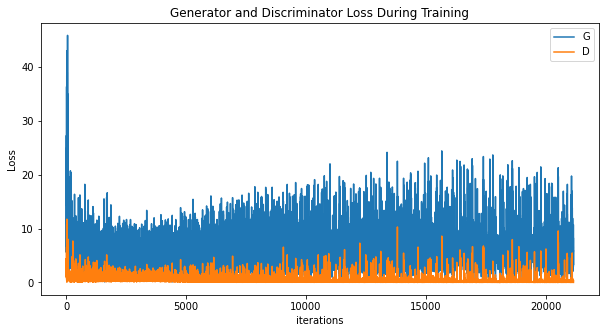

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()